In [18]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.linear_model import Lasso
import time

In [19]:
train_df = pd.read_csv('train.csv', sep=";")
test_df = pd.read_csv('test.csv', sep=";")

df = {
    'train': train_df,
    'test': test_df
}

In [20]:
# Part 1

In [21]:
# Finding null values
null_counts = df['train'].isnull().sum()
print(null_counts)

print("Conclusion: there are no missing data")

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64
Conclusion: there are no missing data


In [22]:
# Finding duplicate values
duplicates = df['train'].duplicated().sum()
print(f'Duplicates: {duplicates}')

print("Conclusion: there are no duplicates")

Duplicates: 0
Conclusion: there are no duplicates


In [23]:
# List all values to determine which columns are numerical vs categorical vs binary
for col in df['train'].columns:
    print(f"\nValue counts for {col}:")
    print(df['train'][col].value_counts())


Value counts for age:
age
32    2085
31    1996
33    1972
34    1930
35    1894
      ... 
95       2
93       2
92       2
88       2
94       1
Name: count, Length: 77, dtype: int64

Value counts for job:
job
blue-collar      9732
management       9458
technician       7597
admin.           5171
services         4154
retired          2264
self-employed    1579
entrepreneur     1487
unemployed       1303
housemaid        1240
student           938
unknown           288
Name: count, dtype: int64

Value counts for marital:
marital
married     27214
single      12790
divorced     5207
Name: count, dtype: int64

Value counts for education:
education
secondary    23202
tertiary     13301
primary       6851
unknown       1857
Name: count, dtype: int64

Value counts for default:
default
no     44396
yes      815
Name: count, dtype: int64

Value counts for balance:
balance
0        3514
1         195
2         156
4         139
3         134
         ... 
14204       1
8205        1
9710   

In [24]:
# Combine day and month to date and then to date_timestamp
month_mapping = {
    'jan': 1,
    'feb': 2,
    'mar': 3,
    'apr': 4,
    'may': 5,
    'jun': 6,
    'jul': 7,
    'aug': 8,
    'sep': 9,
    'oct': 10,
    'nov': 11,
    'dec': 12
}

for key in df:
    df[key]['month_num'] = df[key]['month'].map(month_mapping)
    df[key]['date_timestamp'] = pd.to_datetime(df[key][['day']].assign(year=2008, month=df[key]['month_num'])).astype('int64')

    df[key] = df[key].drop(columns=['day', 'month', 'month_num'])

In [25]:
# Convert categorical columns to category type
categorical_columns = ['job', 'marital', 'education', 'contact', 'poutcome']

for key in df:
    for col in categorical_columns:
        df[key][col] = df[key][col].astype('category')

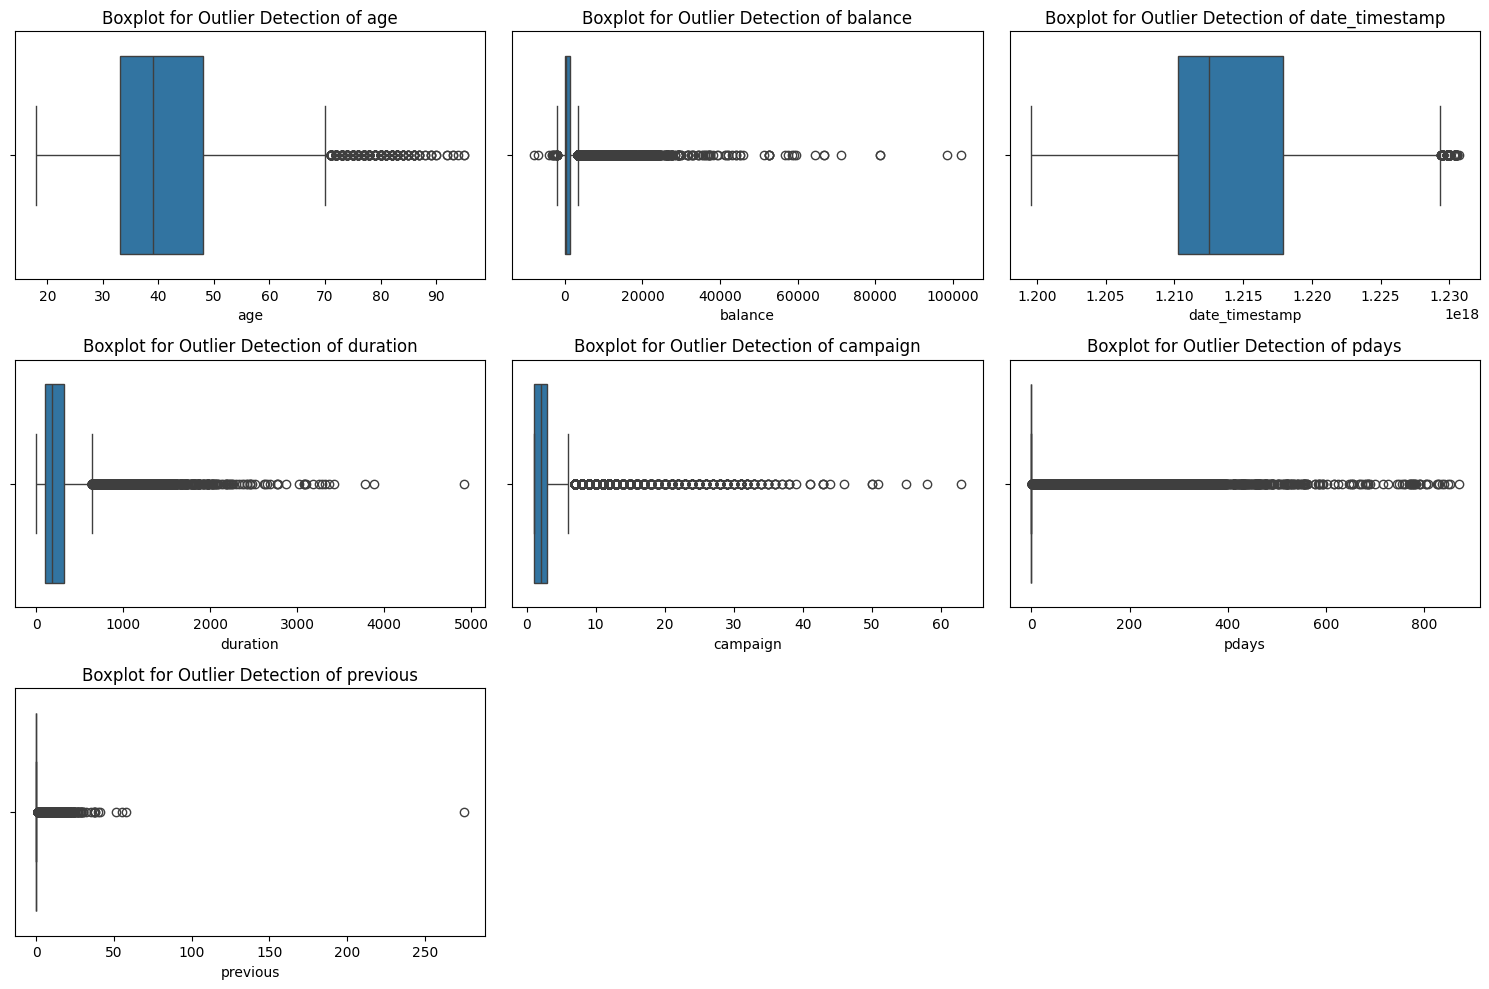

Conclusion: age and date seem to have a good amount of data between the 25th to 75th percentile, we can drop the outliers using these 2 columns


In [26]:
# Visualize which columns to remove outliers for
numerical_columns = ['age', 'balance', 'date_timestamp', 'duration', 'campaign', 'pdays', 'previous']

plt.figure(figsize=(15, 10))

for i, col in enumerate(numerical_columns, 1):
    plt.subplot(3, 3, i)
    sns.boxplot(x=df['train'][col])
    plt.title(f"Boxplot for Outlier Detection of {col}")

plt.tight_layout()
plt.show()

print("Conclusion: age and date seem to have a good amount of data between the 25th to 75th percentile, we can drop the outliers using these 2 columns")

In [27]:
# Remove outliers using the age and date column
columns_to_remove_outliers_for = ['age', 'date_timestamp']
bounds = {}

for col in columns_to_remove_outliers_for:
    q1 = df['train'][col].quantile(0.25)
    q3 = df['train'][col].quantile(0.75)
    iqr = q3 - q1  # Interquartile Range

    # Define bounds for outliers
    bounds[col] = {
        'lower_bound': q1 - 1.5 * iqr,
        'upper_bound': q3 + 1.5 * iqr
    }

for col in columns_to_remove_outliers_for:
    df['train'] = df['train'][(df['train'][col] >= bounds[col]['lower_bound']) & (df['train'][col] <= bounds[col]['upper_bound'])]

df['train'].reset_index(inplace=True, drop=True)

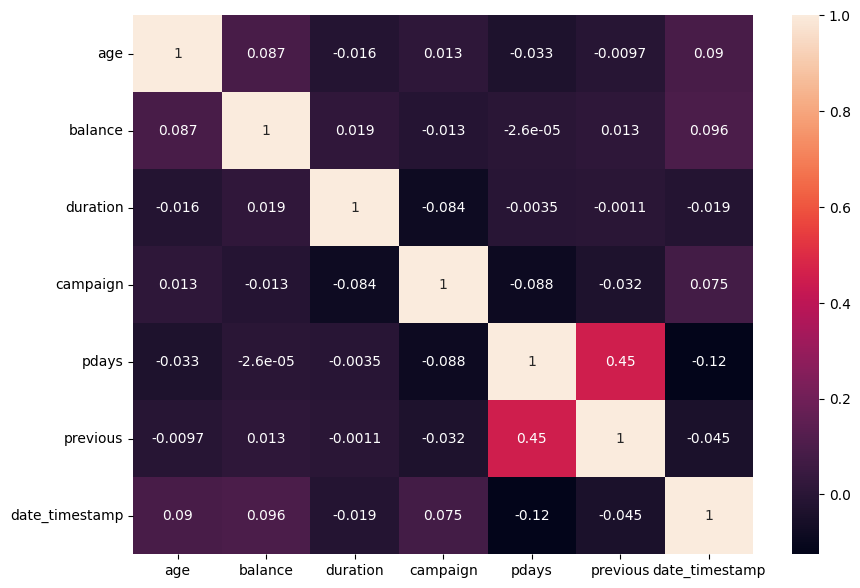

There are no strong correlations between each numeric feature.


In [28]:
# Look for correlations between features
numeric_df = df['train'].select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True)
plt.show()
print("There are no strong correlations between each numeric feature.")

In [29]:
### 新heatmap 

In [30]:
# Create a new column 'y_binary' to store the binary encoding of 'y'
df['train']['y_bin'] = df['train']['y'].map({'yes': 1, 'no': 0})

# Verify the new column
print(df['train'][['y', 'y_bin']].head())

    y  y_bin
0  no      0
1  no      0
2  no      0
3  no      0
4  no      0


In [31]:
df['train'].head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,date_timestamp,y_bin
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,1209945600000000000,0
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,1209945600000000000,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,1209945600000000000,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,1209945600000000000,0
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,1209945600000000000,0


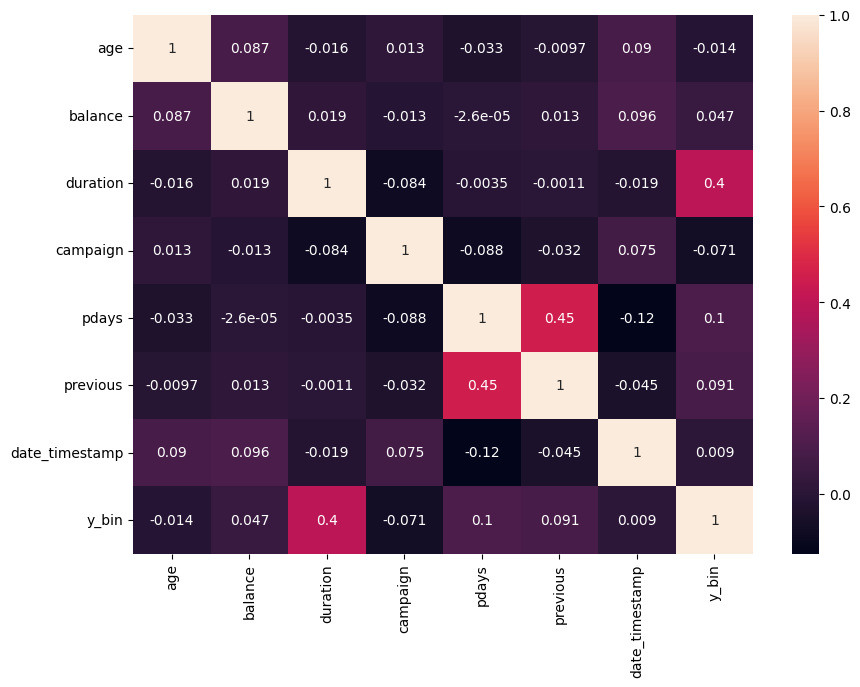

There are no strong correlations between each numeric feature.


In [33]:
# Look for correlations between features
numeric_df = df['train'].select_dtypes(include=['float64', 'int64'])

correlation_matrix = numeric_df.corr()
plt.figure(figsize=(10, 7))
sns.heatmap(correlation_matrix, annot=True)
plt.show()
print("There are no strong correlations between each numeric feature.")

In [34]:
df['train'].head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,date_timestamp,y_bin
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,1209945600000000000,0
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,1209945600000000000,0
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,1209945600000000000,0
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,1209945600000000000,0
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,1209945600000000000,0


In [36]:
# Remove the 'y_bin' column
df['train'] = df['train'].drop(columns=['y_bin'])



KeyError: "['y_bin'] not found in axis"

In [37]:
df['train'].head()

,age,job,marital,education,default,balance,housing,loan,contact,duration,campaign,pdays,previous,poutcome,y,date_timestamp
0,58,management,married,tertiary,no,2143,yes,no,unknown,261,1,-1,0,unknown,no,1209945600000000000
1,44,technician,single,secondary,no,29,yes,no,unknown,151,1,-1,0,unknown,no,1209945600000000000
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,76,1,-1,0,unknown,no,1209945600000000000
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,92,1,-1,0,unknown,no,1209945600000000000
4,33,unknown,single,unknown,no,1,no,no,unknown,198,1,-1,0,unknown,no,1209945600000000000


In [ ]:
# categorical variables

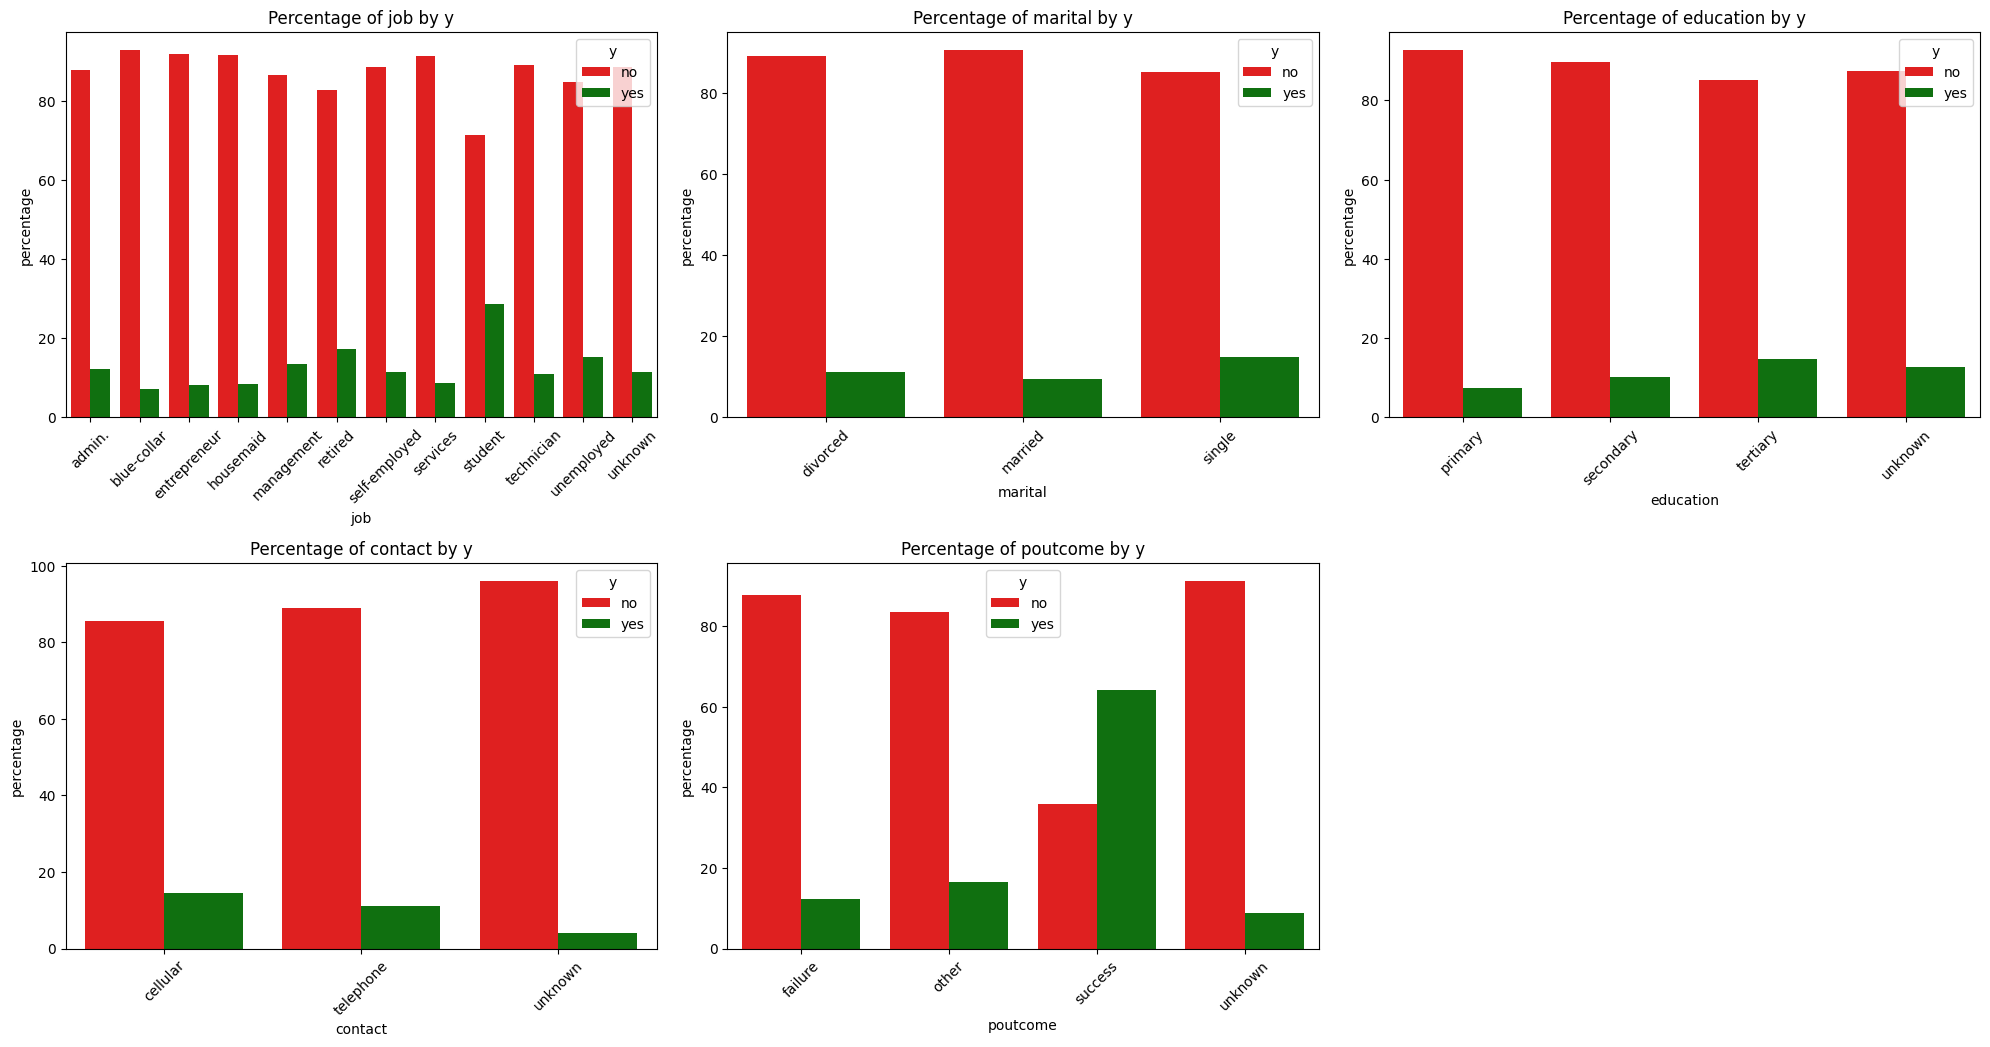

In [38]:

# Create a new figure for the plots
plt.figure(figsize=(20, 15))

for i, col in enumerate(categorical_columns, 1):
    # Create a subplot for each categorical variable
    plt.subplot(3, 3, i)
    
    # Calculate the percentage of 'yes' and 'no' within each category
    category_counts = pd.crosstab(df['train'][col], df['train']['y'], normalize='index') * 100
    
    # Melt the table for easier plotting with seaborn
    category_counts = category_counts.reset_index().melt(id_vars=col, value_vars=['no', 'yes'], var_name='y', value_name='percentage')
    
    # Create a barplot with percentage
    sns.barplot(x=col, y='percentage', hue='y', data=category_counts, palette={'yes': 'green', 'no': 'red'})
    
    # Set the title and rotate x-axis labels for better readability
    plt.title(f'Percentage of {col} by y')
    plt.xticks(rotation=45)

# Adjust the layout
plt.tight_layout()
plt.show()

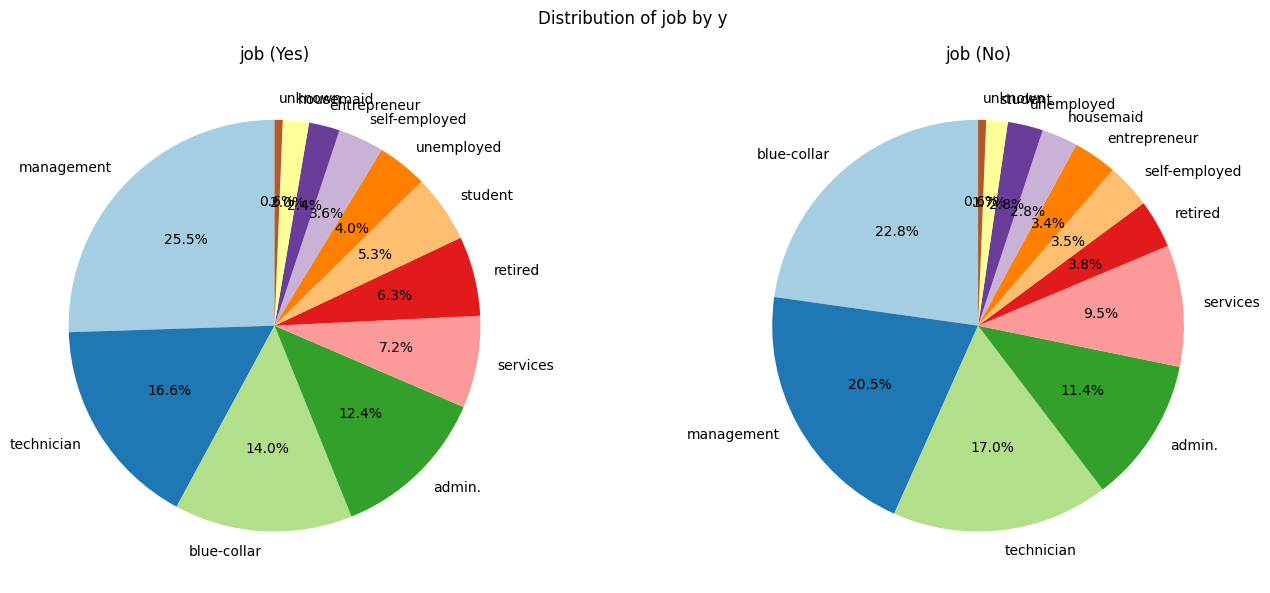

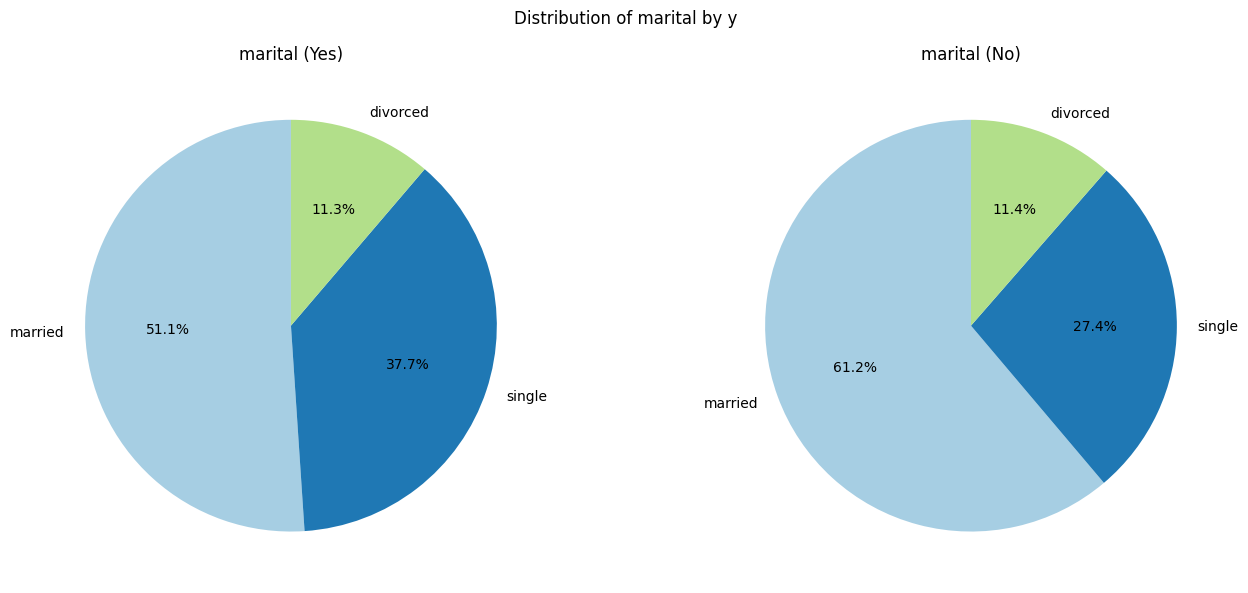

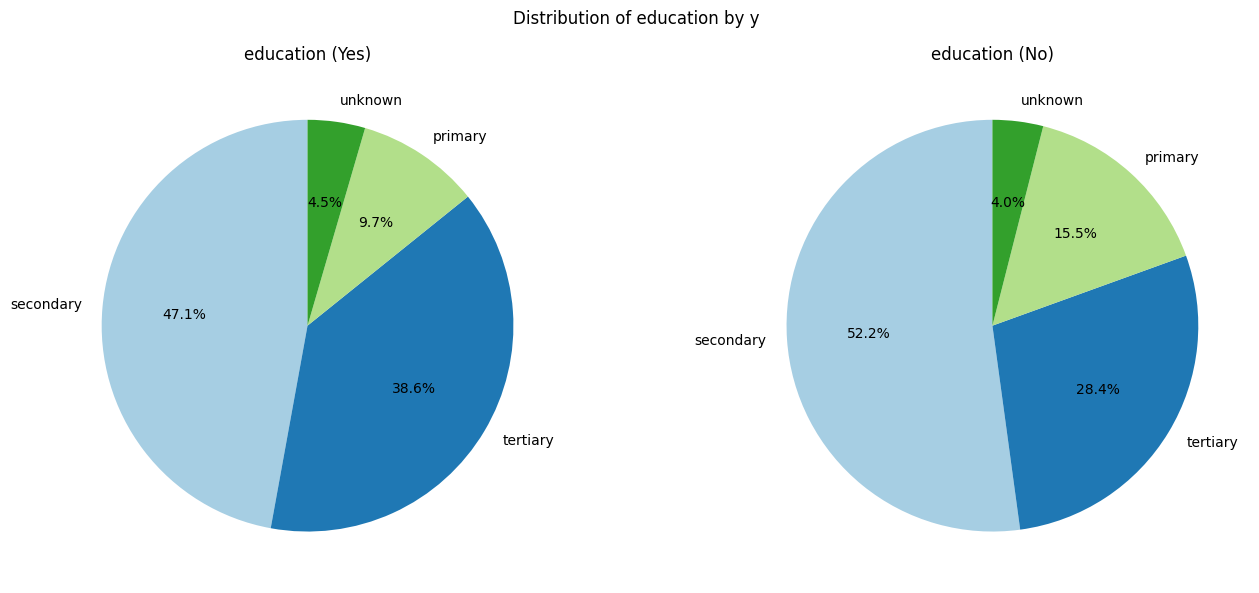

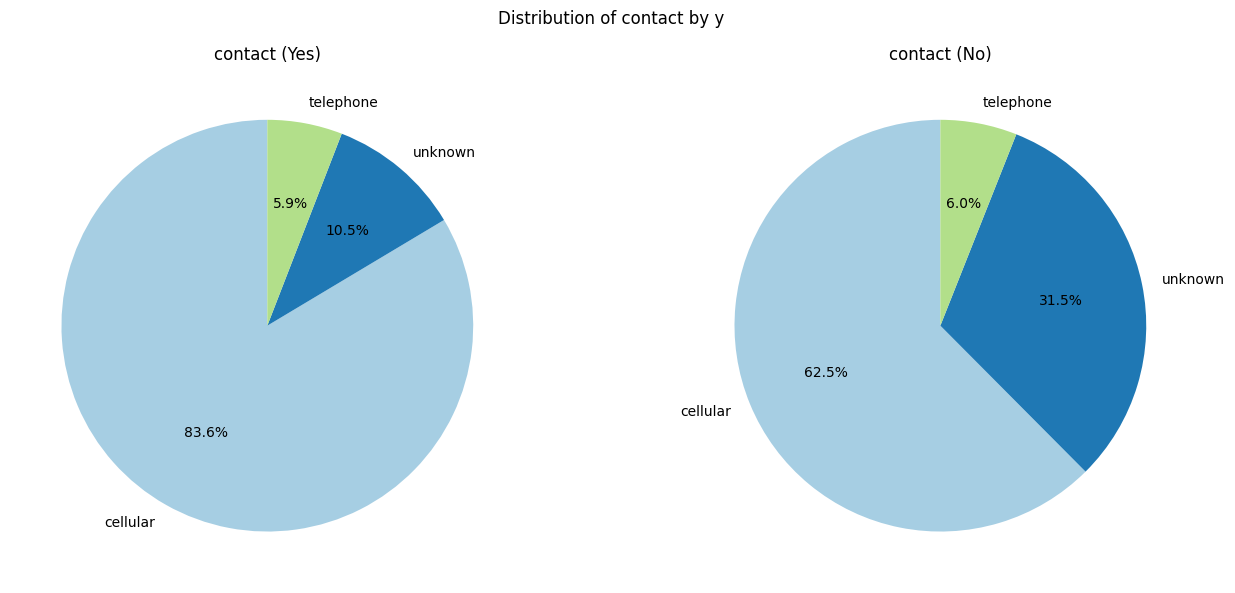

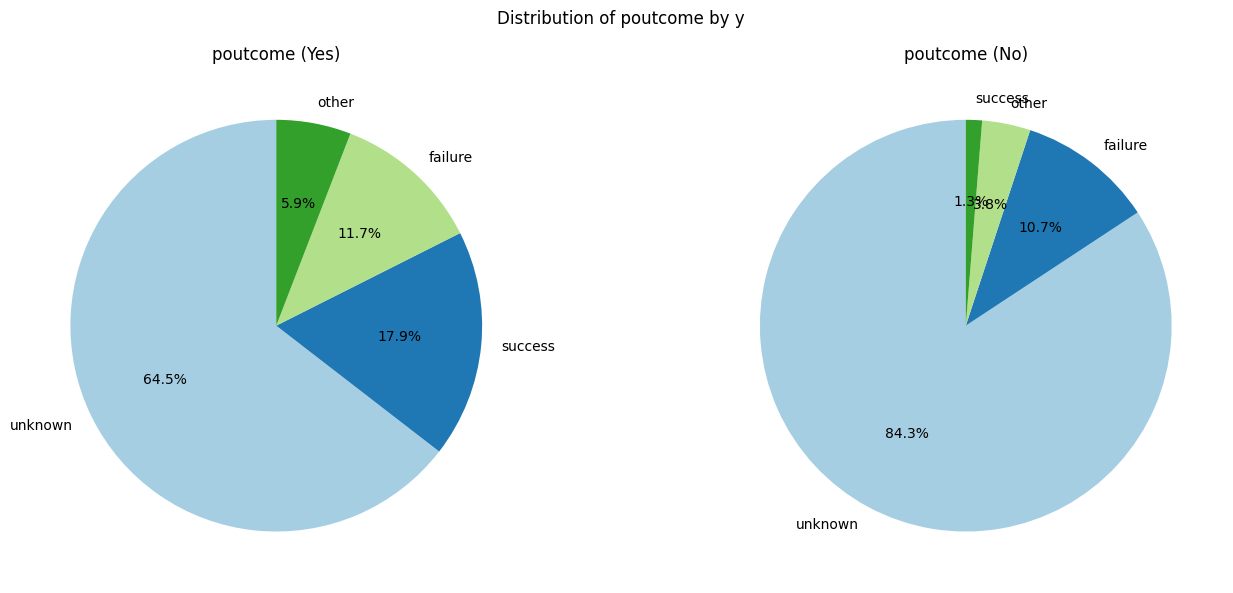

In [41]:
# Plot pie charts for each categorical variable, split by 'y'
for col in categorical_columns:
    # Create a figure with two subplots: one for 'yes' and one for 'no'
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
    
    # Pie chart for 'yes' responses
    yes_data = df['train'][df['train']['y'] == 'yes'][col].value_counts()
    axes[0].pie(yes_data, labels=yes_data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    axes[0].set_title(f'{col} (Yes)')
    
    # Pie chart for 'no' responses
    no_data = df['train'][df['train']['y'] == 'no'][col].value_counts()
    axes[1].pie(no_data, labels=no_data.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Paired.colors)
    axes[1].set_title(f'{col} (No)')
    
    # Display the pie charts
    plt.suptitle(f'Distribution of {col} by y')
    plt.tight_layout()
    plt.show()


In [12]:
# Use StandardScaler to scale numeric columns
scaler = StandardScaler()

df['train'][numerical_columns] = scaler.fit_transform(df['train'][numerical_columns])
df['test'][numerical_columns] = scaler.transform(df['test'][numerical_columns])

In [13]:
# Use OneHotEncoder to encode categorical columns
for key in df:
    for col in categorical_columns:
        encoder = OneHotEncoder(sparse_output=False)
        encoded = encoder.fit_transform(df[key][[col]])
        encoded_df = pd.DataFrame(encoded, columns=encoder.get_feature_names_out([col]))
        df[key] = pd.concat([df[key], encoded_df], axis=1).drop(col, axis=1)

In [14]:
# Convert binary columns to binary value
binary_columns = ['default', 'housing', 'loan', 'y']
for key in df:
    for col in binary_columns:
        df[key][col] = df[key][col].map({'yes': 1, 'no': 0})  

In [15]:
# Split x and y data
y_train = df['train']['y']
x_train = df['train'].drop(columns='y')
y_test = df['test']['y']
x_test = df['test'].drop(columns='y')

In [16]:
# Use lasso regression to remove unimportant features
lasso = Lasso(alpha=0.01)
lasso.fit(x_train, y_train)
important_features = lasso.coef_ != 0
non_zero_indices = np.where(lasso.coef_ != 0)[0]
selected_features = x_train.columns[non_zero_indices]
x_train = x_train[selected_features]
x_test = x_test[selected_features]

display(x_train)

,housing,duration,campaign,pdays,previous,contact_cellular,contact_unknown,poutcome_success
0,1,0.014725,-0.569538,-0.407785,-0.248342,0.0,1.0,0.0
1,1,-0.412860,-0.569538,-0.407785,-0.248342,0.0,1.0,0.0
2,1,-0.704395,-0.569538,-0.407785,-0.248342,0.0,1.0,0.0
3,1,-0.642201,-0.569538,-0.407785,-0.248342,0.0,1.0,0.0
4,0,-0.230165,-0.569538,-0.407785,-0.248342,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
44633,0,0.034160,-0.569538,-0.407785,-0.248342,1.0,0.0,0.0
44634,0,0.500616,-0.248073,-0.407785,-0.248342,1.0,0.0,0.0
44635,0,2.797912,0.073391,-0.407785,-0.248342,1.0,0.0,0.0
44636,0,0.974847,0.394856,-0.407785,-0.248342,0.0,0.0,0.0


In [17]:
# Conclusion:
print("Conclusion:")
print("- There are no missing data or duplicate data")
print("- Created a date column based on the month and day columns present in the dataset, this is more meaningful than month and day alone")
print("- Converted the date into timestamp format so it can be scaled later")
print("- Converted categorical columns to type category")
print("- Plotted boxplots for train set and noticed age and date seem to have a good amount of data between the 25th to 75th percentile, thus dropped the outliers using these 2 columns")
print("- Used StandardScaler to scale all numeric columns, this way algorithms like KNN will be able to function properly, used the scaler obtained from the train set to scale the test set")
print("- Used OneHotEncoder to encode all categorical columns, since not all algorithms can handle non-numeric data and that ordinal encoding may introduce unnecessary correlations between columns")
print("- Convert the binary columns into binary values for easy comparison")
print("- Lastly, split the x and y data of both the train and test set")

Conclusion:
- There are no missing data or duplicate data
- Created a date column based on the month and day columns present in the dataset, this is more meaningful than month and day alone
- Converted the date into timestamp format so it can be scaled later
- Converted categorical columns to type category
- Plotted boxplots for train set and noticed age and date seem to have a good amount of data between the 25th to 75th percentile, thus dropped the outliers using these 2 columns
- Used StandardScaler to scale all numeric columns, this way algorithms like KNN will be able to function properly, used the scaler obtained from the train set to scale the test set
- Used OneHotEncoder to encode all categorical columns, since not all algorithms can handle non-numeric data and that ordinal encoding may introduce unnecessary correlations between columns
- Convert the binary columns into binary values for easy comparison
- Lastly, split the x and y data of both the train and test set


In [18]:
# Part 2

In [19]:
# Set up metrics
metrics = {
    'time_to_run': {},
    'f1_weighted_avg': {},
    'roc_auc': {},
}

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.98      0.95      4000
           1       0.64      0.30      0.41       521

    accuracy                           0.90      4521
   macro avg       0.78      0.64      0.68      4521
weighted avg       0.88      0.90      0.88      4521

Confusion Matrix:
            pred_no  pred_yes
actual_no      3912        88
actual_yes      366       155
Best Parameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


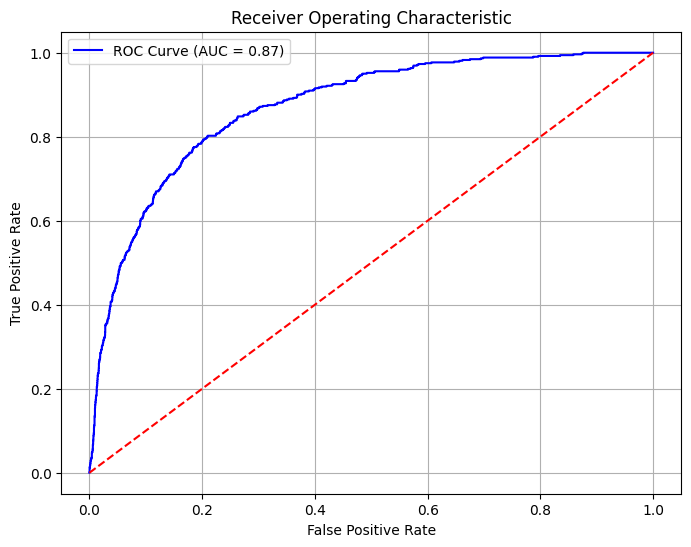

There is an imbalance between the support of true positives and true negatives, with an overwhelming amount more of true positives.
Therefore, it makes sense to use a weighted average, and the weighted average for f1 score is a good indicator of this being a good model with f1-weighted-avg = 0.882995766983184
The ROC Curve also looks good with a good AUC score of 0.8705595009596929


In [20]:
# Build a logistic regression model
start_time = time.time()

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l2', 'l1'],  # Regularization type
    'solver': ['liblinear']  # Suitable solver for l1 and l2
}

model = LogisticRegression()

model.fit(x_train, y_train)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
y_prob = best_model.predict_proba(x_test)[:, 1]

end_time = time.time()

cr = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred))

x_labels = ['pred_no', 'pred_yes']
y_labels = ['actual_no', 'actual_yes']
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=y_labels, columns = x_labels))
print("Best Parameters:", grid_search.best_params_)

roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid()
plt.show()

f1_weighted_avg = float(cr['weighted avg']['f1-score'])
roc_auc_float = float(roc_auc)

metrics['time_to_run']['logistic_regression'] = float(end_time - start_time)
metrics['f1_weighted_avg']['logistic_regression'] = f1_weighted_avg
metrics['roc_auc']['logistic_regression'] = roc_auc_float

print("There is an imbalance between the support of true positives and true negatives, with an overwhelming amount more of true positives.")
print(f"Therefore, it makes sense to use a weighted average, and the weighted average for f1 score is a good indicator of this being a good model with f1-weighted-avg = {str(f1_weighted_avg)}")
print(f"The ROC Curve also looks good with a good AUC score of {str(roc_auc_float)}")

/Users/owner/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.95      4000
           1       0.63      0.37      0.47       521

    accuracy                           0.90      4521
   macro avg       0.78      0.67      0.71      4521
weighted avg       0.89      0.90      0.89      4521

Confusion Matrix:
            pred_no  pred_yes
actual_no      3887       113
actual_yes      327       194
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'uniform'}


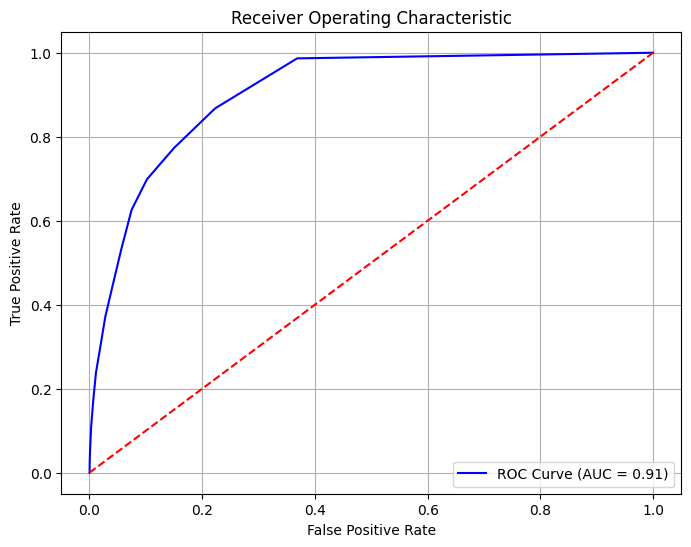

There is an imbalance between the support of the true positives and true negatives, with an overwhelming amount more of true positives.
Therefore, it makes sense to use a weighted average, and the weighted average for f1 score is a good indicator of this being a good model with f1-weighted-avg = 0.8913673466582452
The ROC Curve also looks good with a good AUC score of 0.9055458253358925


In [21]:
# Build a KNN model
start_time = time.time()

param_grid = {
    'n_neighbors': [1, 5, 9, 11, 15],  # Different values for number of neighbors
    'metric': ['euclidean', 'manhattan'],  # Distance metrics
    'weights': ['uniform', 'distance']  # Weighting schemes
}

knn = KNeighborsClassifier()

knn.fit(x_train, y_train)
grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
y_prob = best_model.predict_proba(x_test)[:, 1]

end_time = time.time()

cr = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred))

x_labels = ['pred_no', 'pred_yes']
y_labels = ['actual_no', 'actual_yes']
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=y_labels, columns = x_labels))
print("Best Parameters:", grid_search.best_params_)

roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid()
plt.show()

f1_weighted_avg = float(cr['weighted avg']['f1-score'])
roc_auc_float = float(roc_auc)

metrics['time_to_run']['knn'] = float(end_time - start_time)
metrics['f1_weighted_avg']['knn'] = f1_weighted_avg
metrics['roc_auc']['knn'] = roc_auc_float

print("There is an imbalance between the support of the true positives and true negatives, with an overwhelming amount more of true positives.")
print(f"Therefore, it makes sense to use a weighted average, and the weighted average for f1 score is a good indicator of this being a good model with f1-weighted-avg = {str(f1_weighted_avg)}")
print(f"The ROC Curve also looks good with a good AUC score of {str(roc_auc_float)}")

In [22]:
# Part 3

/Users/owner/Library/Python/3.9/lib/python/site-packages/numpy/ma/core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      4000
           1       0.76      0.40      0.52       521

    accuracy                           0.92      4521
   macro avg       0.84      0.69      0.74      4521
weighted avg       0.91      0.92      0.90      4521

Confusion Matrix:
            pred_no  pred_yes
actual_no      3936        64
actual_yes      315       206
Best Parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}


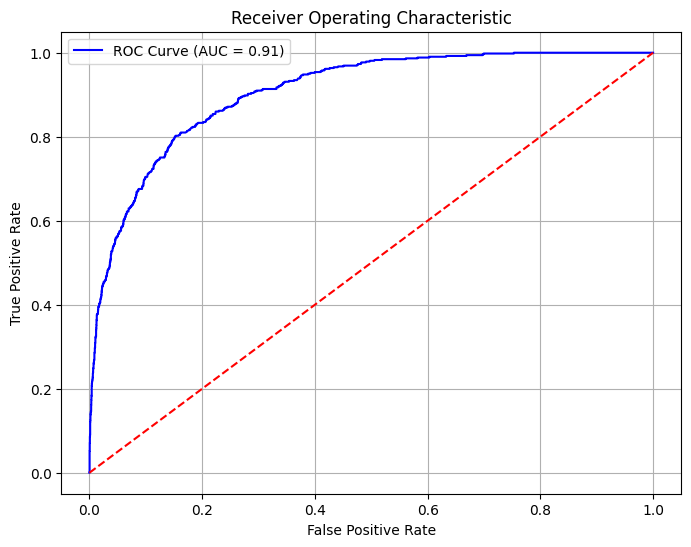

In [23]:
# Build a random forest model
start_time = time.time()

param_grid = {
    'n_estimators': [50, 100],  # Number of trees
    'max_depth': [None, 10, 20],  # Maximum depth of trees
    'min_samples_split': [2, 5],  # Minimum samples to split an internal node
    'min_samples_leaf': [1, 2],  # Minimum samples at a leaf node
    'max_features': ['log2', 'sqrt']  # Number of features to consider
}

model = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
y_prob = best_model.predict_proba(x_test)[:, 1]

end_time = time.time()

cr = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred))

x_labels = ['pred_no', 'pred_yes']
y_labels = ['actual_no', 'actual_yes']
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=y_labels, columns = x_labels))
print("Best Parameters:", grid_search.best_params_)

roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid()
plt.show()

metrics['time_to_run']['random_forest'] = float(end_time - start_time)
metrics['f1_weighted_avg']['random_forest'] = float(cr['weighted avg']['f1-score'])
metrics['roc_auc']['random_forest'] = float(roc_auc)

/Users/owner/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/owner/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/owner/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/Users/owner/Library/Python/3.9/lib/python/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm t

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.97      0.94      4000
           1       0.61      0.34      0.44       521

    accuracy                           0.90      4521
   macro avg       0.76      0.66      0.69      4521
weighted avg       0.88      0.90      0.89      4521

Confusion Matrix:
            pred_no  pred_yes
actual_no      3886       114
actual_yes      343       178
Best Parameters: {'estimator': DecisionTreeClassifier(max_depth=1), 'learning_rate': 1.0, 'n_estimators': 100}


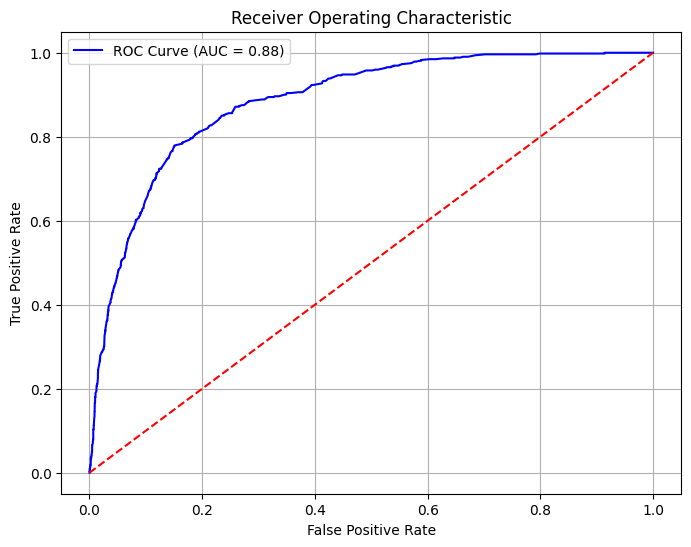

In [24]:
# Build an AdaBoost model
start_time = time.time()

param_grid = {
    'n_estimators': [50, 100, 200],  # Number of estimators
    'learning_rate': [0.01, 0.1, 1.0],  # Learning rate
    'estimator': [DecisionTreeClassifier(max_depth=1), DecisionTreeClassifier(max_depth=2)]
}

model = AdaBoostClassifier(random_state=42)
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
y_prob = best_model.predict_proba(x_test)[:, 1]

end_time = time.time()

cr = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred))

x_labels = ['pred_no', 'pred_yes']
y_labels = ['actual_no', 'actual_yes']
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=y_labels, columns = x_labels))
print("Best Parameters:", grid_search.best_params_)

roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid()
plt.show()

metrics['time_to_run']['adaboost'] = float(end_time - start_time)
metrics['f1_weighted_avg']['adaboost'] = float(cr['weighted avg']['f1-score'])
metrics['roc_auc']['adaboost'] = float(roc_auc)

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.98      0.95      4000
           1       0.68      0.41      0.51       521

    accuracy                           0.91      4521
   macro avg       0.80      0.69      0.73      4521
weighted avg       0.90      0.91      0.90      4521

Confusion Matrix:
            pred_no  pred_yes
actual_no      3901        99
actual_yes      309       212
Best Parameters: {'estimator': KNeighborsClassifier(), 'max_features': 1.0, 'max_samples': 0.5, 'n_estimators': 100}


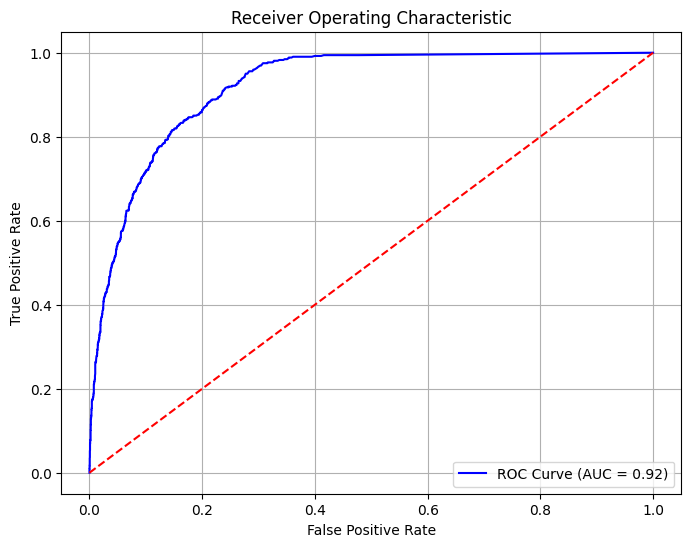

In [25]:
# Build a bagging classifier using different base estimators
start_time = time.time()

param_grid = {
    'n_estimators': [50, 100],  # Number of base estimators
    'max_samples': [0.5, 1.0],  # Proportion of samples for each base estimator
    'max_features': [0.5, 1.0],  # Proportion of features for each base estimator
    'estimator': [
        DecisionTreeClassifier(max_depth=1),
        KNeighborsClassifier(n_neighbors=5),
        RandomForestClassifier(n_estimators=10)
    ]
}

bagging_model = BaggingClassifier(random_state=42)
grid_search = GridSearchCV(bagging_model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
y_prob = best_model.predict_proba(x_test)[:, 1]

end_time = time.time()

cr = classification_report(y_test, y_pred, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred))

x_labels = ['pred_no', 'pred_yes']
y_labels = ['actual_no', 'actual_yes']
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=y_labels, columns = x_labels))
print("Best Parameters:", grid_search.best_params_)

roc_auc = roc_auc_score(y_test, y_prob)

fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid()
plt.show()

metrics['time_to_run']['bagging_classifier'] = float(end_time - start_time)
metrics['f1_weighted_avg']['bagging_classifier'] = float(cr['weighted avg']['f1-score'])
metrics['roc_auc']['bagging_classifier'] = float(roc_auc)

Hard voting:
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4000
           1       0.73      0.37      0.49       521

    accuracy                           0.91      4521
   macro avg       0.83      0.68      0.72      4521
weighted avg       0.90      0.91      0.90      4521

Confusion Matrix:
            pred_no_hard  pred_yes_hard
actual_no           3901             99
actual_yes           309            212
ROC_AUC curve not supported for hard voting
------------------------------------------------------------------------------------
Soft voting:
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      4000
           1       0.73      0.38      0.50       521

    accuracy                           0.91      4521
   macro avg       0.83      0.68      0.72      4521
weighted avg       0.90      0.91      0.90      4521

Confusi

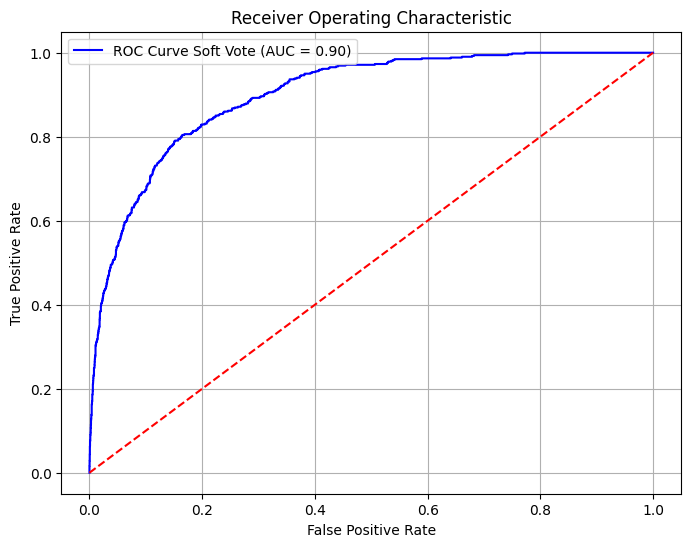

In [26]:
# Build a voting classifier model using different classification models as well as both hard and soft voting
start_time = time.time()

log_clf = LogisticRegression(C=0.01, penalty='l2', solver='liblinear')
tree_clf = DecisionTreeClassifier(max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=2)
rf_clf = RandomForestClassifier(max_depth=10, max_features='log2', min_samples_leaf=1, min_samples_split=2, n_estimators=50)

voting_clf_hard = VotingClassifier(
    estimators=[('lr', log_clf), ('dt',tree_clf), ('rf',rf_clf)],
    voting='hard'
)

voting_clf_soft = VotingClassifier(
    estimators=[('lr', log_clf), ('dt',tree_clf), ('rf',rf_clf)],
    voting='soft'
)

voting_clf_hard.fit(x_train, y_train)

voting_clf_soft.fit(x_train, y_train)

y_pred_hard = voting_clf_hard.predict(x_test)

y_pred_soft = voting_clf_soft.predict(x_test)
y_prob_soft = voting_clf_soft.predict_proba(x_test)[:, 1]

end_time = time.time()

print("Hard voting:")
cr = classification_report(y_test, y_pred_hard, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred_hard))

x_labels = ['pred_no_hard', 'pred_yes_hard']
y_labels = ['actual_no', 'actual_yes']
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred), index=y_labels, columns = x_labels))

print("ROC_AUC curve not supported for hard voting")

metrics['time_to_run']['voting_classifier_hard'] = float(end_time - start_time)
metrics['f1_weighted_avg']['voting_classifier_hard'] = float(cr['weighted avg']['f1-score'])
metrics['roc_auc']['voting_classifier_hard'] = 0.0

print("------------------------------------------------------------------------------------")

print("Soft voting:")
cr = classification_report(y_test, y_pred_soft, output_dict=True)
print("Classification Report:")
print(classification_report(y_test, y_pred_soft))

x_labels = ['pred_no_soft', 'pred_yes_Soft']
y_labels = ['actual_no', 'actual_yes']
print("Confusion Matrix:")
print(pd.DataFrame(confusion_matrix(y_test, y_pred_soft), index=y_labels, columns = x_labels))

roc_auc = roc_auc_score(y_test, y_prob_soft)

fpr, tpr, thresholds = roc_curve(y_test, y_prob_soft)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC Curve Soft Vote (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Diagonal line for random chance
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend()
plt.grid()
plt.show()

metrics['time_to_run']['voting_classifier_soft'] = float(end_time - start_time)
metrics['f1_weighted_avg']['voting_classifier_soft'] = float(cr['weighted avg']['f1-score'])
metrics['roc_auc']['voting_classifier_soft'] = float(roc_auc)


In [27]:
# Part 4

In [28]:
# Print the time to run each algorithm and the performance of said algorithm
display(pd.DataFrame(metrics))

min_time_to_run_value = min(metrics['time_to_run'].values())
min_time_to_run_key = min(metrics['time_to_run'], key=(metrics['time_to_run'].get))

max_f1_weighted_avg_value = max(metrics['f1_weighted_avg'].values())
max_f1_weighted_avg_key = max(metrics['f1_weighted_avg'], key=(metrics['f1_weighted_avg'].get))

max_roc_auc_value = max(metrics['roc_auc'].values())
max_roc_auc_key = max(metrics['roc_auc'], key=(metrics['roc_auc'].get))

print(f"Min time to run: {min_time_to_run_key} = {min_time_to_run_value}")
print(f"Max f1 weighted average: {max_f1_weighted_avg_key} = {max_f1_weighted_avg_value}")
print(f"Max ROC AUC score: {max_roc_auc_key} = {max_roc_auc_value}")

,time_to_run,f1_weighted_avg,roc_auc
logistic_regression,27.661944,0.882996,0.870560
knn,75.718692,0.891367,0.905546
random_forest,373.569443,0.904143,0.905375
adaboost,151.793664,0.886086,0.884157
bagging_classifier,1278.372378,0.899519,0.919270
voting_classifier_hard,4.066056,0.898672,0.000000
voting_classifier_soft,4.066056,0.899406,0.899710


Min time to run: voting_classifier_hard = 4.066055774688721
Max f1 weighted average: random_forest = 0.9041434602824334
Max ROC AUC score: bagging_classifier = 0.9192701535508637


In [29]:
# Part 5

In [30]:
# Why did the ensemble models perform the way they did?
print("Random forest:")
print(f" - Performs well in both f1 ({str(metrics['f1_weighted_avg']['random_forest'])}) and ROC-AUC ({str(metrics['roc_auc']['random_forest'])}), indicating balanced predictions across classes and good discriminationg ability")
print(" - It aggregates the predictions of many decision trees, which likely conributes to its strong performace on diverse data")
print(f" - The long runtime of {str(metrics['time_to_run']['random_forest'])}s is likely due to needing to train many deep decision trees")
print()

print("Adaboost:")
print(f" - Slightly lower f1 ({str(metrics['f1_weighted_avg']['adaboost'])}) and ROC-AUC scores ({str(metrics['roc_auc']['adaboost'])}) compared to Random Forest")
print(" - Adaboost uses a sequential process to emphasize misclassified instances, which can work well for imbalanced datasets but can sometimes underperform if data is noisy or not linearly separable")
print(f" - The longer run time of {str(metrics['time_to_run']['adaboost'])}s is due to the iterative nature of boosting, where each weak learner is trained sequentially")
print(" - Adaboost tends to perform better if the data is clean and relatively easy to classify, the lower scores suggests that the dataset is noisy and is mostly expected")
print()

print("Bagging classifier:")
print(f" - High ROC-AUC ({str(metrics['roc_auc']['bagging_classifier'])}) and decent f1 ({str(metrics['f1_weighted_avg']['bagging_classifier'])}) suggest that this model has very good class separation but may have some misclassifications affecting precision or recall")
print(f" - Its significantly longer run time ({str(metrics['time_to_run']['bagging_classifier'])}s) reflects the high computational cost of bagging, where multiple models are trained on bootstrapped samples and aggregated")
print(" - Bagging trains multiple versions of a model on different bootstrapped subsets of the data, so it tends to reduce variance and overfitting, which is why it has such a high ROC-AUC")
print(" - The extremely high ROC-AUX score is expected, since bagging often excels in improving generalization, however the training time is also expected to be very long")
print()

print("Voting classifier hard:")
print(" - Hard voting uses majority voting from different classifiers")
print(f" - This yields stable and robust result by combining the strengths of multiple models, the f1 score ({str(metrics['f1_weighted_avg']['voting_classifier_hard'])}) is decent")
print(f" - There is no model training which is why it runs very fast, taking only {str(metrics['time_to_run']['voting_classifier_hard'])}s")
print(" - Unlike models like Adaboost or Bagging, voting classifier doesn't require iterative training of weak learners or resampling of data, this is why it's very fast")
print()

print("Voting classifer soft:")
print(" - Soft voting averages the probablities instead, this yields stable and robust result much like hard voting")
print(f" - Soft voting may perform slightly better tthan hard voting in terms of f1 score ({str(metrics['f1_weighted_avg']['voting_classifier_soft'])}) and ROC-AUC ({str(metrics['roc_auc']['voting_classifier_soft'])}) since it leverages probability estimates from the classifiers rather than just their hard predictions")
print(f" - The run speed is also very fast ({str(metrics['time_to_run']['voting_classifier_soft'])}s), this is expected to perform at least as well as the best models in the ensemble")


Random forest:
 - Performs well in both f1 (0.9041434602824334) and ROC-AUC (0.9053752399232247), indicating balanced predictions across classes and good discriminationg ability
 - It aggregates the predictions of many decision trees, which likely conributes to its strong performace on diverse data
 - The long runtime of 373.5694432258606s is likely due to needing to train many deep decision trees

Adaboost:
 - Slightly lower f1 (0.886086386519446) and ROC-AUC scores (0.8841573896353168) compared to Random Forest
 - Adaboost uses a sequential process to emphasize misclassified instances, which can work well for imbalanced datasets but can sometimes underperform if data is noisy or not linearly separable
 - The longer run time of 151.79366397857666s is due to the iterative nature of boosting, where each weak learner is trained sequentially
 - Adaboost tends to perform better if the data is clean and relatively easy to classify, the lower scores suggests that the dataset is noisy and is 

In [31]:
# If you had to pick one model to implement in business process, which would it be and why?
print(f"We would pick the soft voting classifier since it runs very fast ({str(metrics['time_to_run']['voting_classifier_soft'])}s), and has good f1 ({str(metrics['f1_weighted_avg']['voting_classifier_soft'])}) and ROC-AUC ({str(metrics['roc_auc']['voting_classifier_soft'])}).")
print(f"It performs comparably to another really good model - Bagging classifier which while has high f1 ({str(metrics['f1_weighted_avg']['bagging_classifier'])}) and ROC-AUC ({str(metrics['roc_auc']['bagging_classifier'])})")
print(f"it has a horrible run time of {str(metrics['time_to_run']['bagging_classifier'])}s, computation is very costly for businesses as that would mean the business needs to purchase higher end devices to run the Bagging model,")
print("while only getting marginal improvements on performance sometimes")

We would pick the soft voting classifier since it runs very fast (4.066055774688721s), and has good f1 (0.8994060266455755) and ROC-AUC (0.8997096928982726).
It performs comparably to another really good model - Bagging classifier which while has high f1 (0.8995194961692556) and ROC-AUC (0.9192701535508637)
it has a horrible run time of 1278.3723781108856s, computation is very costly for businesses as that would mean the business needs to purchase higher end devices to run the Bagging model,
while only getting marginal improvements on performance sometimes


In [32]:
# What decision criteria did you use to arrive at this conclusion?
print("We mainly used the f1 score which combines the precision-recall trade-off and gives a balanced score. We picked a model that had comparably high f1 weighted average, this meant the model performed well.")
print(f"In this dataset, we see most of the models perform comparably to each other, but the soft voting classifier stands out in not only being high in f1 score ({str(metrics['f1_weighted_avg']['voting_classifier_soft'])}), but also was the fastest ({str(metrics['time_to_run']['voting_classifier_soft'])}s) algorithm to run.")

We mainly used the f1 score which combines the precision-recall trade-off and gives a balanced score. We picked a model that had comparably high f1 weighted average, this meant the model performed well.
In this dataset, we see most of the models perform comparably to each other, but the soft voting classifier stands out in not only being high in f1 score (0.8994060266455755), but also was the fastest (4.066055774688721s) algorithm to run.
